In [1]:
# Importing the necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import datetime
from operator import itemgetter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
from sklearn.mixture import GaussianMixture


In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 400)

## Loading Dataframes

In [3]:
df = pd.read_pickle("./Data/dataframefull.pickle")
df_user = pd.read_pickle("./Data/users.pickle")
df_month = pd.read_pickle("./Data/months.pickle")

In [4]:
df_user_std = df_user.copy()
df_user_mm = df_user.copy()

In [6]:
df_user.head()

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim
0,1,147.01,6,1,0,0,73.505,2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,first,Germany,Lower Saxony,Varel,desktop,Firefox,Windows,Germany
1,2,208.34,8,0,0,0,208.340,1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,first,Germany,Mecklenburg-Vorpommern,Stralsund,desktop,Internet Explorer,Windows,Germany
2,3,84.11,0,1,0,0,84.110,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Lower Saxony,Buchholz in der Nordheide,tablet,Safari,iOS,Germany
3,4,62.32,1,4,0,0,62.320,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Berlin,Berlin,desktop,Chrome,Windows,Germany
4,5,89.89,0,0,4,0,44.945,2,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Schleswig-Holstein,Neumunster,tablet,Safari,iOS,Germany


In [7]:
df_month.head()

,year_month,revenue,monthly_growth_revenue,avg_shop_cart,avg_cart_itemcount,active_customers,total_purchases,women_article,men_article,kids_article,homeandliving_article,revenue_first,revenue_established,first_user_count,established_user_count,retained_user_count,retention_rate,ratio_first_to_established
0,201711,5.268517e+06,0.000000,103.495016,3.466743,46985,50906,96910,61491,14107,999,5.268517e+06,0.00,46985,0,46985,1.000000,0.000000
1,201712,4.983451e+06,-0.054108,90.652698,3.284649,50004,54973,95202,64962,15461,1806,4.619641e+06,363809.47,46799,3205,3205,0.064095,14.601872
2,201801,3.717325e+06,-0.254066,87.034361,3.661563,38221,42711,89365,52416,10983,1100,3.216473e+06,500851.97,33596,4625,3141,0.082180,7.264000
3,201802,3.056483e+06,-0.177773,90.680675,3.791995,30837,33706,67535,42438,14910,795,2.526812e+06,529670.62,26114,4723,2520,0.081720,5.529113
4,201803,6.210612e+06,1.031947,108.247849,3.966274,52209,57374,139458,66852,18202,964,5.122223e+06,1088389.01,44512,7697,2797,0.053573,5.783032


## Preparation for Kmeans (dummies and scaling)

In [8]:
user_dum = pd.get_dummies(df_user.drop(columns=["user_id", "region", "city","country"]))
#region and city need to be dropped as the computing power needed to do this exceeds the given

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
user_scale_std = scaler.fit_transform(user_dum)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
user_scale_mm = scaler.fit_transform(user_dum)

## Elbow method 

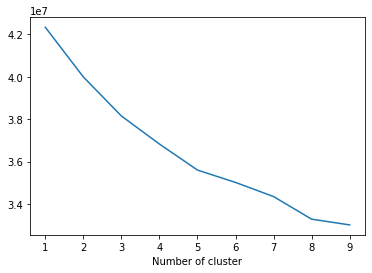

In [11]:
from sklearn.cluster import KMeans

sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_scale_std)
    #df_user["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

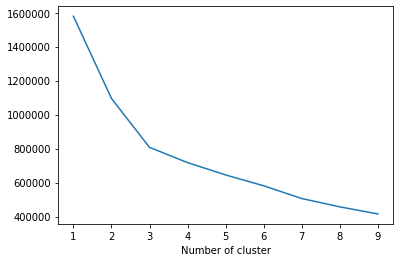

In [12]:
from sklearn.cluster import KMeans

sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_scale_mm)
    #df_user["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

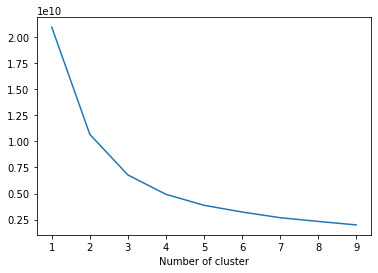

In [13]:
from sklearn.cluster import KMeans

sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_dum)
    #df_user["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

## Clustering and Evaluation

In [14]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final



## cluster with user_dum unscaled

In [15]:
kmeans = KMeans(n_clusters=4, max_iter=1000)
kmeans.fit(user_dum)
df_user['cluster'] = kmeans.predict(user_dum)

In [16]:
ordered_by_rev = order_cluster('cluster', 'revenue',df_user,False)

In [17]:
ordered_by_rev.groupby('cluster').describe()

user_id                                                           \
            count           mean            std    min       25%       50%   
cluster                                                                      
0          3353.0  310162.448852  177923.970671  121.0  162373.0  306391.0   
1         38735.0  310040.529263  179744.255184   22.0  153843.0  309508.0   
2        154198.0  311301.549216  179494.475915    2.0  155770.5  311579.5   
3        426331.0  311436.926290  179834.770725    1.0  155739.5  311404.0   

                               revenue                                   \
               75%       max     count         mean         std     min   
cluster                                                                   
0        461138.00  622509.0    3353.0  1417.785652  659.666064  942.84   
1        465350.50  622613.0   38735.0   491.791279  145.269318  311.81   
2        466325.75  622606.0  154198.0   203.872059   60.573315  122.65   
3        467365.50  622618.0  426331.0    61.645107   32.463675    0.00   

                                              women_article             \
              25%      50%      75%       max         count       mean   
cluster                                                                  
0        1056.880  1222.32  1544.99  21205.01        3353.0  36.270504   
1         383.425   452.42   562.92   1001.06       38735.0  10.664076   
2         153.750   191.56   243.67    410.99      154198.0   4.302728   
3          33.610    55.45    84.02    195.25      426331.0   1.336023   

                                                 men_article             \
               std  min   25%   50%   75%    max       count       mean   
cluster                                                                   
0        25.065461  0.0  23.0  33.0  46.0  532.0      3353.0  11.495079   
1         8.021971  0.0   4.0  10.0  15.0   67.0     38735.0   4.993262   
2         3.743360  0.0   1.0   4.0   7.0   34.0    154198.0   2.396536   
3         1.572592  0.0   0.0   1.0   2.0   20.0    426331.0   1.001862   

                                               kids_article            \
               std  min  25%  50%   75%    max        count      mean   
cluster                                                                 
0        16.231527  0.0  1.0  5.0  16.0  209.0       3353.0  2.676707   
1         6.821003  0.0  0.0  2.0   8.0   76.0      38735.0  0.997702   
2         3.576356  0.0  0.0  0.0   4.0   37.0     154198.0  0.512380   
3         1.653927  0.0  0.0  0.0   2.0   27.0     426331.0  0.281378   

                                             homeandliving_article            \
              std  min  25%  50%  75%    max                 count      mean   
cluster                                                                        
0        7.362169  0.0  0.0  0.0  1.0  125.0                3353.0  0.188488   
1        3.536665  0.0  0.0  0.0  0.0   85.0               38735.0  0.049387   
2        2.115521  0.0  0.0  0.0  0.0   44.0              154198.0  0.028094   
3        1.172258  0.0  0.0  0.0  0.0   37.0              426331.0  0.020740   

                                            avg_shop_cart              \
              std  min  25%  50%  75%   max         count        mean   
cluster                                                                 
0        1.005782  0.0  0.0  0.0  0.0  19.0        3353.0  212.035179   
1        0.444135  0.0  0.0  0.0  0.0  20.0       38735.0  270.466949   
2        0.302139  0.0  0.0  0.0  0.0  13.0      154198.0  162.350217   
3        0.197530  0.0  0.0  0.0  0.0  10.0      426331.0   56.260600   

                                                                       \
                std        min         25%      50%      75%      max   
cluster                                                                 
0        130.983709  34.235172  127.299286  183.380  263.455  2099.47   
1        132.47

In [28]:
df_user.groupby(["cluster"]).agg({
    "revenue": "mean",
    "women_article": "sum",
    "men_article": "sum",
    "kids_article": "sum",
    "homeandliving_article": "sum",
    "avg_shop_cart": "mean",
    "total_purchases": "mean",
    "avg_cart_itemcount": "mean",
    "monday": "mean",
    "tuesday": "mean",
    "wednesday": "mean",
    "thursday": "mean",
    "friday": "mean",
    "saturday": "mean",
    "sunday": ["mean", "count"],
    #"user_type": "mode"  
})#.round(0)

revenue women_article men_article kids_article  \
                mean           sum         sum          sum   
cluster                                                       
0          61.645107        569588      427125       119960   
1        1417.785652        121615       38543         8975   
2         203.872059        663472      369541        79008   
3         491.791279        413073      193414        38646   

        homeandliving_article avg_shop_cart total_purchases  \
                          sum          mean            mean   
cluster                                                       
0                        8842     56.260600        1.120266   
1                         632    212.035179        9.097226   
2                        4332    162.350217        1.465577   
3                        1913    270.466949        2.606144   

        avg_cart_itemcount    monday   tuesday wednesday  thursday    friday  \
                      mean      mean      mean      mean      mean      mean   
cluster                                                                        
0                 2.399971  0.135885  0.151326  0.128987  0.162512  0.153709   
1                 7.344472  1.000298  1.162541  0.977930  1.337012  1.195944   
2                 5.636155  0.170080  0.192175  0.169451  0.211546  0.191896   
3                 8.683555  0.290074  0.339899  0.288060  0.375268  0.337860   

         saturday    sunday          
             mean      mean   count  
cluster                              
0        0.181120  0.199437  426331  
1        1.527885  1.617059    3353  
2        0.236177  0.277546  154198  
3        0.436711  0.494282   38735

cluster 0 and 1 denote only about 2% of the customers, but these have the highest value <br>
cluster 2 has 57000 users , about 9% of the customers, are still valueable, mostly those customers that purchase more often<br>
cluster 3 a bit more than a average of 1 time customers, but with a way higher avg. purchase value than cluster 4, abput 27% <br> 
cluster 4 customers who mostly bought only once, about 61%

## cluster with user_dum std scale

In [33]:
kmeans = KMeans(n_clusters=3, max_iter=1000)
kmeans.fit(user_scale_std)
df_user_std['cluster'] = kmeans.predict(user_scale_std)

In [34]:
ordered_by_rev_std = order_cluster('cluster', 'revenue',df_user_std,False)

In [35]:
ordered_by_rev_std.groupby('cluster').describe()

user_id                                                          \
            count           mean            std   min       25%       50%   
cluster                                                                     
0         82853.0  311272.164894  179302.075633  22.0  156451.0  311109.0   
1        240777.0  311397.657658  179770.382464   1.0  155487.0  311418.0   
2        298987.0  311249.186767  179825.999005   3.0  155599.5  311284.0   

                              revenue                                       \
              75%       max     count        mean         std  min     25%   
cluster                                                                      
0        466085.0  622613.0   82853.0  328.793834  323.208745  0.0  136.93   
1        467075.0  622618.0  240777.0  103.733776   92.515162  0.0   41.97   
2        467116.5  622617.0  298987.0   98.007576   87.575471  0.0   39.30   

                                   women_article                            \
            50%      75%       max         count      mean        std  min   
cluster                                                                      
0        237.77  411.040  21205.01       82853.0  8.072067  10.168994  0.0   
1         74.78  133.590   1160.34      240777.0  1.978013   2.785801  0.0   
2         68.20  125.685    975.48      298987.0  2.082676   2.695157  0.0   

                               men_article                                     \
         25%  50%   75%    max       count      mean       std  min  25%  50%   
cluster                                                                         
0        2.0  5.0  11.0  532.0     82853.0  3.580148  6.257593  0.0  0.0  1.0   
1        0.0  1.0   3.0   36.0    240777.0  1.649630  2.711823  0.0  0.0  0.0   
2        0.0  1.0   3.0   35.0    298987.0  1.119795  2.193866  0.0  0.0  0.0   

                    kids_article                                          \
         75%    max        count      mean       std  min  25%  50%  75%   
cluster                                                                    
0        5.0  209.0      82853.0  0.968812  3.359787  0.0  0.0  0.0  0.0   
1        2.0   50.0     240777.0  0.296025  1.354488  0.0  0.0  0.0  0.0   
2        1.0   35.0     298987.0  0.317887  1.384223  0.0  0.0  0.0  0.0   

               homeandliving_article                                          \
           max                 count      mean       std  min  25%  50%  75%   
cluster                                                                        
0        125.0               82853.0  0.051428  0.430540  0.0  0.0  0.0  0.0   
1         44.0              240777.0  0.022411  0.229711  0.0  0.0  0.0  0.0   
2         37.0              298987.0  0.020275  0.214334  0.0  0.0  0.0  0.0   

              avg_shop_cart                                             \
          max         count        mean        std  min     25%    50%   
cluster                                                                  
0        20.0       82853.0  105.181515  72.756009  0.0  54.355  85.82   
1        16.0      240777.0   98.554730  85.670984  0.0  40.330  71.40   
2        12.0      298987.0   92.856517  81.140755  0.0  38.000  67.21   

                             total_purchases                                \
                75%      max           count      mean       std  min  25%   
cluster                                                                      
0        135.086667  2099.47         82853.0  3.186861  2.450177  1.0  2.0   
1        126.030000  1159.57        240777.0  1.055832  0.252890  1.0  1.0   
2        117.630000   975.48        298987.0  1.059524  0.260939  1.0  1.0   

                         avg_cart_itemcount                                \
         50%  75%    max              count      mean       std  min  25%   
cluster                                                                     
0        2.0  3.0  126.0            828

seems that there is no good outcome whatsoever with a standardscaler.

In [36]:
df_user_std.groupby(["cluster"]).agg({
    "revenue": "mean",
    "women_article": "sum",
    "men_article": "sum",
    "kids_article": "sum",
    "homeandliving_article": "sum",
    "avg_shop_cart": "mean",
    "total_purchases": "mean",
    "avg_cart_itemcount": "mean",
    "monday": "mean",
    "tuesday": "mean",
    "wednesday": "mean",
    "thursday": "mean",
    "friday": "mean",
    "saturday": "mean",
    "sunday": ["mean", "count"],
    #"user_type": "mode"  
})#.round(0)

revenue women_article men_article kids_article  \
               mean           sum         sum          sum   
cluster                                                      
0        103.733776        476260      397193        71276   
1        328.793834        668795      296626        80269   
2         98.007576        622693      334804        95044   

        homeandliving_article avg_shop_cart total_purchases  \
                          sum          mean            mean   
cluster                                                       
0                        5396     98.554730        1.055832   
1                        4261    105.181515        3.186861   
2                        6062     92.856517        1.059524   

        avg_cart_itemcount    monday   tuesday wednesday  thursday    friday  \
                      mean      mean      mean      mean      mean      mean   
cluster                                                                        
0                 3.779687  0.134714  0.144229  0.127068  0.156315  0.145724   
1                 4.063804  0.359504  0.421638  0.346783  0.472246  0.413359   
2                 3.366332  0.122166  0.138973  0.121176  0.147695  0.143428   

         saturday    sunday          
             mean      mean   count  
cluster                              
0        0.151323  0.189092  240777  
1        0.538641  0.588971   82853  
2        0.182653  0.194202  298987

## cluster with user_dum MM scale

In [37]:
kmeans = KMeans(n_clusters=3, max_iter=1000)
kmeans.fit(user_scale_mm)
df_user_mm['cluster'] = kmeans.predict(user_scale_mm)

In [38]:
ordered_by_rev_mm = order_cluster('cluster', 'revenue',df_user_mm,False)

In [39]:
ordered_by_rev_mm.groupby('cluster').describe()

user_id                                                         \
            count           mean            std  min       25%       50%   
cluster                                                                    
0        191445.0  311249.739137  179931.358121  6.0  155341.0  311019.0   
1        275429.0  311316.372372  179733.785683  1.0  155456.0  311378.0   
2        155743.0  311371.449535  179494.931621  3.0  156394.0  311523.0   

                              revenue                                      \
              75%       max     count        mean         std  min    25%   
cluster                                                                     
0        467086.0  622616.0  191445.0  132.311200  170.897802  0.0  42.01   
1        466875.0  622618.0  275429.0  131.711305  157.694616  0.0  44.52   
2        466968.0  622617.0  155743.0  127.863360  166.397869  0.0  42.01   

                                 women_article                                \
           50%     75%       max         count      mean       std  min  25%   
cluster                                                                        
0        80.66  157.09   6267.30      191445.0  3.087336  5.250368  0.0  0.0   
1        84.02  159.65   6112.63      275429.0  2.670852  4.678845  0.0  0.0   
2        80.65  152.47  21205.01      155743.0  2.831992  5.004043  0.0  0.0   

                         men_article                                          \
         50%  75%    max       count      mean       std  min  25%  50%  75%   
cluster                                                                        
0        2.0  4.0  282.0    191445.0  1.377900  3.039569  0.0  0.0  0.0  2.0   
1        1.0  3.0  209.0    275429.0  1.989017  3.652591  0.0  0.0  1.0  3.0   
2        1.0  4.0  532.0    155743.0  1.393308  2.941176  0.0  0.0  0.0  2.0   

               kids_article                                                 \
           max        count      mean       std  min  25%  50%  75%    max   
cluster                                                                      
0        195.0     191445.0  0.404795  1.846290  0.0  0.0  0.0  0.0  125.0   
1        209.0     275429.0  0.370989  1.701514  0.0  0.0  0.0  0.0   85.0   
2         84.0     155743.0  0.429631  1.846337  0.0  0.0  0.0  0.0   59.0   

        homeandliving_article                                                \
                        count      mean       std  min  25%  50%  75%   max   
cluster                                                                       
0                    191445.0  0.021897  0.248690  0.0  0.0  0.0  0.0  20.0   
1                    275429.0  0.026497  0.264319  0.0  0.0  0.0  0.0  16.0   
2                    155743.0  0.027154  0.263069  0.0  0.0  0.0  0.0  13.0   

        avg_shop_cart                                                       \
                count       mean        std  min    25%        50%     75%   
cluster                                                                      
0            191445.0  92.638522  78.456878  0.0  39.98  67.220000  117.64   
1            275429.0  99.554992  84.471116  0.0  42.01  73.923333  127.71   
2            155743.0  96.644433  81.572287  0.0  41.17  71.183333  124.33   

                 total_purchases                                          \
             max           count      mean       std  min  25%  50%  75%   
cluster                                                                    
0         975.48        191445.0  1.412406  1.337959  1.0  1.0  1.0  1.0   
1        2099.47        275429.0  1.316118  1.105581  1.0  1.0  1.0  1.0   
2        1138.39        155743.0  1.297972  1.068799  1.0  1.0  1.0  1.0   

               avg_cart_itemcount                                          \
           max              count      mean       std  min  25%  50%  75%   
cluster                                                                     
0         55.0           19

In [40]:
df_user_mm.groupby(["cluster"]).agg({
    "revenue": "mean",
    "women_article": "sum",
    "men_article": "sum",
    "kids_article": "sum",
    "homeandliving_article": "sum",
    "avg_shop_cart": "mean",
    "total_purchases": "mean",
    "avg_cart_itemcount": "mean",
    "monday": "mean",
    "tuesday": "mean",
    "wednesday": "mean",
    "thursday": "mean",
    "friday": "mean",
    "saturday": "mean",
    "sunday": ["mean", "count"],
    #"user_type": "mode"  
})#.round(0)

revenue women_article men_article kids_article  \
               mean           sum         sum          sum   
cluster                                                      
0        132.311200        591055      263792        77496   
1        131.711305        735630      547833       102181   
2        127.863360        441063      216998        66912   

        homeandliving_article avg_shop_cart total_purchases  \
                          sum          mean            mean   
cluster                                                       
0                        4192     92.638522        1.412406   
1                        7298     99.554992        1.316118   
2                        4229     96.644433        1.297972   

        avg_cart_itemcount    monday   tuesday wednesday  thursday    friday  \
                      mean      mean      mean      mean      mean      mean   
cluster                                                                        
0                 3.393956  0.159111  0.186544  0.159200  0.200031  0.189893   
1                 3.831725  0.164667  0.178050  0.155376  0.195070  0.178979   
2                 3.519423  0.147249  0.169889  0.143082  0.185562  0.170589   

         saturday    sunday          
             mean      mean   count  
cluster                              
0        0.242900  0.255828  191445  
1        0.193810  0.239172  275429  
2        0.229808  0.241032  155743

## scores (easier?)

std

In [37]:
km_scores_std = []
km_silhouette_std = []
vmeasure_score_std =[]
db_score_std = []
for i in range(2,10):
    km = KMeans(n_clusters=i, random_state=0, n_jobs=-1).fit(user_scale_std)
    preds = km.predict(user_scale_std)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(user_scale_std)))
    km_scores_std.append(-km.score(user_scale_std))
    
    #silhouette = silhouette_score(user_scale_std,preds)
    #km_silhouette.append(silhouette)
    #print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(user_scale_std,preds)
    db_score_std.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
    #v_measure = v_measure_score(y,preds)
    #vmeasure_score.append(v_measure)
    #print("V-measure score for number of cluster(s) {}: {}".format(i,v_measure))
    #print("-"*100)

Score for number of cluster(s) 2: -39993673.539483
Davies Bouldin score for number of cluster(s) 2: 3.084420864314706
Score for number of cluster(s) 3: -38151677.00138855
Davies Bouldin score for number of cluster(s) 3: 2.6684086752203484
Score for number of cluster(s) 4: -36844947.6261874
Davies Bouldin score for number of cluster(s) 4: 2.429067656575418
Score for number of cluster(s) 5: -35599691.71899528
Davies Bouldin score for number of cluster(s) 5: 1.9427752156956994
Score for number of cluster(s) 6: -34881720.19371477
Davies Bouldin score for number of cluster(s) 6: 1.8968626133034645
Score for number of cluster(s) 7: -34293283.84473896
Davies Bouldin score for number of cluster(s) 7: 1.4524160115970393
Score for number of cluster(s) 8: -33471260.010843866
Davies Bouldin score for number of cluster(s) 8: 1.812607099127524
Score for number of cluster(s) 9: -32226040.981937606
Davies Bouldin score for number of cluster(s) 9: 1.6124422071110631


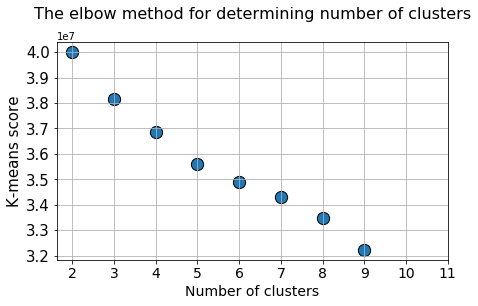

In [38]:
plt.figure(figsize=(7,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,10)],y=km_scores_std,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

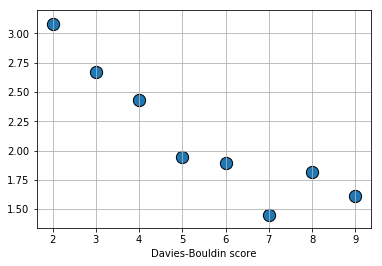

In [39]:
plt.scatter(x=[i for i in range(2,10)],y=db_score_std,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Davies-Bouldin score")
plt.show()

minmax

In [34]:
km_scores_mm = []
km_silhouette_mm = []
vmeasure_score_mm =[]
db_score_mm = []
for i in range(2,10):
    km = KMeans(n_clusters=i, random_state=0, n_jobs=-1).fit(user_scale_mm)
    preds = km.predict(user_scale_mm)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(user_scale_mm)))
    km_scores_mm.append(-km.score(user_scale_mm))
    
    #silhouette = silhouette_score(user_scale_mm,preds)
    #km_silhouette.append(silhouette)
    #print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(user_scale_mm,preds)
    db_score_mm.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
    #v_measure = v_measure_score(y,preds)
    #vmeasure_score.append(v_measure)
    #print("V-measure score for number of cluster(s) {}: {}".format(i,v_measure))
    #print("-"*100)

Score for number of cluster(s) 2: -1095069.1920719314
Davies Bouldin score for number of cluster(s) 2: 1.4223826510462672
Score for number of cluster(s) 3: -807111.1736564833
Davies Bouldin score for number of cluster(s) 3: 1.139270900019804
Score for number of cluster(s) 4: -717477.6897347833
Davies Bouldin score for number of cluster(s) 4: 1.2859295751264421
Score for number of cluster(s) 5: -648748.6352908359
Davies Bouldin score for number of cluster(s) 5: 1.1553348617985502
Score for number of cluster(s) 6: -573544.1493252423
Davies Bouldin score for number of cluster(s) 6: 1.0547451540839987
Score for number of cluster(s) 7: -521801.546469498
Davies Bouldin score for number of cluster(s) 7: 1.2800319938336828
Score for number of cluster(s) 8: -457140.9813684305
Davies Bouldin score for number of cluster(s) 8: 1.1304327975590316
Score for number of cluster(s) 9: -410621.05875132605
Davies Bouldin score for number of cluster(s) 9: 1.075923649874048


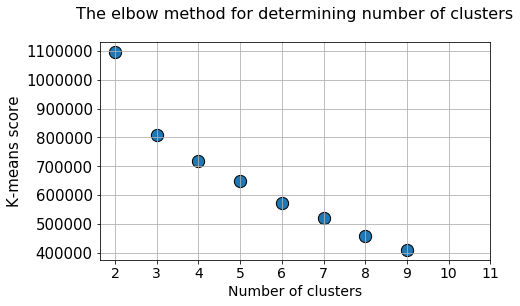

In [35]:
plt.figure(figsize=(7,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,10)],y=km_scores_mm,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

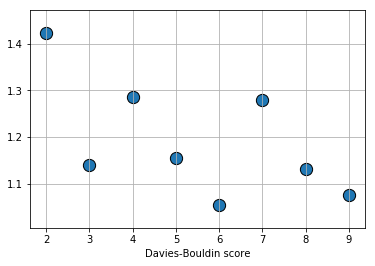

In [36]:
plt.scatter(x=[i for i in range(2,10)],y=db_score_mm,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Davies-Bouldin score")
plt.show()

## Gaussian Mixture

In [33]:
'''gm_bic= []
gm_score=[]
for i in range(2,12):
    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(user_scale_std)
    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(user_scale_std)))
    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(user_scale_std)))
    print("-"*100)
    gm_bic.append(-gm.bic(user_scale_std))
    gm_score.append(gm.score(user_scale_std))'''

'gm_bic= []\ngm_score=[]\nfor i in range(2,12):\n    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(user_scale)\n    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(user_scale)))\n    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(user_scale)))\n    print("-"*100)\n    gm_bic.append(-gm.bic(user_scale))\n    gm_score.append(gm.score(user_scale))'

In [ ]:
'''plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic),s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Log of Gaussian mixture BIC score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()'''